In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf

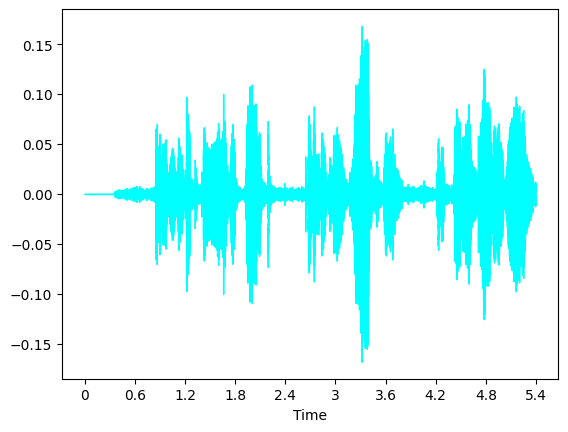

In [46]:
y,sr=librosa.load('C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Personalized\Vocal\Splitted\Happy\Happy_out_1.m4a') #load the file
librosa.display.waveshow(y,sr=sr, x_axis='time', color='cyan')

In [4]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [2]:
root_path = 'C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Personalized\Vocal'
emotions = {'01':'Happy', '02':'Sad', '03':'Angry', '04':'Neutral'}
observed_emotions = ['Happy', 'Sad', 'Angry', 'Neutral']
data_sources = [root_path+'\\Splitted',root_path+'\\SplittedClear', root_path+'\\SplittedNoisy\\Uniform',
                root_path+'\\SplittedNoisy\\Gaussian', root_path+'\\SplittedNoisy\\Pink', root_path+'\\SplittedNoisy\\Periodic']

In [3]:
def create_spectrogram(audio_file):
    fig = plt.figure(figsize=(224/100, 224/100), dpi=100)  # Set figure size based on target size
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    # Convert the figure to a numpy array without the alpha channel
    fig.canvas.draw()
    fig_array = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]

    plt.close(fig)

    return fig_array

In [6]:
def generate_features(y_cut):
    max_size=1000 #my max audio file feature width
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=255, hop_length = 512)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_mfcc=128),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [83]:
import matplotlib.pyplot as plt

def draw_spectrogram_from_array(spectrogram_array):
    plt.imshow(spectrogram_array)
    plt.axis('off')  # Turn off axis
    plt.show()

# Assuming you have the spectrogram_array from previous steps

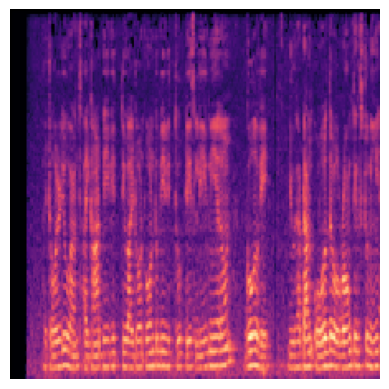

In [84]:
draw_spectrogram_from_array(image1)

In [39]:
def load_data(test_size=0.2):
    x,y = [],[]
    for class_id,folder in enumerate(observed_emotions):
        filepath = os.path.join("C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Personalized\Vocal\Splitted",folder)
        i = 0
        for filename in os.listdir(filepath):
            print(os.path.join(filepath,filename))
            audio, sample_rate = librosa.load(os.path.join(filepath,filename),sr=28000)
            feature = generate_features(audio)
            print(np.sum(feature))
            x.append(feature[np.newaxis,...])
            y.append(class_id)
            i = i+1
            if i == 5:
                break
    x_train,x_test,y_train,y_test = train_test_split(np.array(x),y,test_size=0.25, train_size=0.75, random_state=9)
    train_output=np.concatenate(x_train,axis=0)
    test_output=np.concatenate(x_test,axis=0)
    return np.array(train_output), np.array(test_output), y_train, y_test
    

In [4]:
def load_data_new():
    x,y = [],[]
    for class_id,folder in enumerate(observed_emotions):
        filepath = os.path.join("C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal",folder)
        i=0
        for filename in os.listdir(filepath):
            print(os.path.join(filepath,filename))
            image = create_spectrogram(os.path.join(filepath,filename))
            x.append(image)
            y.append(class_id)
            i=i+1
            if i==600:
                break
    return train_test_split(x,y,stratify=y, test_size=0.25, random_state=0)
    

In [5]:
x_train, x_test, y_train, y_test = load_data_new()

C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_DFA_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_IEO_HAP_HI.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_IEO_HAP_LO.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_IEO_HAP_MD.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_IOM_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_ITH_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_ITS_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_IWL_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_IWW_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_MTI_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Common\Vocal\Happy\1001_TAI_HAP_XX.wav
C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Data

In [47]:
for j,i in enumerate(x_train[0]):
    print(j,np.sum(i))

for j,i in enumerate(x_train[0][1]):
    print(j,np.sum(i))


0 -80358.20422866847
1 19230.554962410548
2 2580.913475021989
3 5498.091770963597
4 5198.108670965114
5 4074.872364752475
6 1095.673195484611
7 3621.1482221949555
8 359.30034040597457
9 2501.168673811444
10 -896.3925623987234
11 1630.5942825482161
12 -536.3369324669111
13 1274.6556380713682
14 -1357.5701556195963
15 1870.8003854975977
16 -1111.199581044981
17 731.9666402351208
18 -151.30119073060632
19 1467.988204082627
20 -2171.7555409030065
21 526.2236391379583
22 196.36749169317773
23 1082.7769962397397
24 -1215.4877453684348
25 1194.540514035023
26 -645.4224640173179
27 1201.5584114489684
28 -388.8055221908144
29 1554.2862636394548
30 -296.8925063979335
31 928.2424078128929
32 481.99580573840467
33 800.3357749743991
34 -314.9967948483718
35 805.6408402518355
36 -496.5805943079995
37 612.1617986279234
38 -699.6298715345765
39 659.7258692527976
40 -323.33748443091827
41 382.5594504365654
42 -602.1938234695517
43 387.4410073780382
44 -549.363881948619
45 211.46220046989174
46 -341.626

In [6]:
from tensorflow.keras.utils import to_categorical

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [7]:
y_test_encoded.shape

(600, 4)

In [48]:
y_test

[0, 1, 1, 1, 3]

In [53]:
input_shape=(128,1000,3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)     

In [9]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=20)

Epoch 1/20


180/180 [==============================] - 196s 1s/step - loss: 1.1637 - accuracy: 0.4644 - val_loss: 0.9481 - val_accuracy: 0.6000
Epoch 2/20
180/180 [==============================] - 179s 993ms/step - loss: 0.9475 - accuracy: 0.6022 - val_loss: 0.9231 - val_accuracy: 0.5917
Epoch 3/20
180/180 [==============================] - 181s 1s/step - loss: 0.8785 - accuracy: 0.6444 - val_loss: 0.8978 - val_accuracy: 0.6150
Epoch 4/20
180/180 [==============================] - 177s 986ms/step - loss: 0.8328 - accuracy: 0.6561 - val_loss: 0.8707 - val_accuracy: 0.6300
Epoch 5/20
180/180 [==============================] - 178s 986ms/step - loss: 0.7489 - accuracy: 0.7011 - val_loss: 0.8572 - val_accuracy: 0.6200
Epoch 6/20
180/180 [==============================] - 178s 992ms/step - loss: 0.7074 - accuracy: 0.7161 - val_loss: 0.9036 - val_accuracy: 0.6317
Epoch 7/20
180/180 [==============================] - 179s 997ms/step - loss: 0.6153 - accuracy: 0.7600 - val_loss: 0.9282 - val

[]

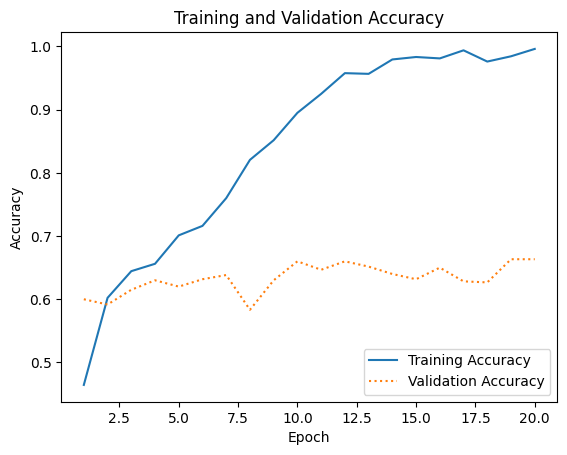

In [10]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [11]:
import joblib

# Assuming 'model' is your trained scikit-learn model
model_path = "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Models\TrainedUsing75persCommonDataCNN.pkl"
joblib.dump(model, model_path)

['C:\\Ruchira\\Academic\\.IMMEDIATE\\FYP\\FYP\\Models\\TrainedUsing75persCommonDataCNN.pkl']

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

19/19 [==============================] - 12s 608ms/step


In [13]:
test_features.shape

(600, 7, 7, 1280)

In [14]:
model1 = Sequential()
model1.add(Flatten(input_shape=train_features.shape[1:]))
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(4, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
hist = model1.fit(train_features, y_train_encoded, validation_data=(test_features, y_test_encoded), batch_size=10, epochs=20)

Epoch 1/20
180/180 [==============================] - 148s 814ms/step - loss: 12.3268 - accuracy: 0.5667 - val_loss: 2.3904 - val_accuracy: 0.6150
Epoch 2/20
180/180 [==============================] - 146s 812ms/step - loss: 0.9398 - accuracy: 0.7767 - val_loss: 1.5910 - val_accuracy: 0.6750
Epoch 3/20
180/180 [==============================] - 146s 809ms/step - loss: 0.5047 - accuracy: 0.8489 - val_loss: 1.4335 - val_accuracy: 0.6833
Epoch 4/20
180/180 [==============================] - 145s 807ms/step - loss: 0.2396 - accuracy: 0.9161 - val_loss: 1.6054 - val_accuracy: 0.6750
Epoch 5/20
180/180 [==============================] - 146s 812ms/step - loss: 0.1174 - accuracy: 0.9606 - val_loss: 1.3566 - val_accuracy: 0.6917
Epoch 6/20
180/180 [==============================] - 146s 813ms/step - loss: 0.0641 - accuracy: 0.9778 - val_loss: 1.2922 - val_accuracy: 0.7000
Epoch 7/20
180/180 [==============================] - 145s 808ms/step - loss: 0.0358 - accuracy: 0.9906 - val_loss: 1.6927 

In [16]:
import joblib

# Assuming 'model' is your trained scikit-learn model
model_path = "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Models\TrainedUsing75percCommonDataMobileNetV2.pkl"
joblib.dump(model1, model_path)

['C:\\Ruchira\\Academic\\.IMMEDIATE\\FYP\\FYP\\Models\\TrainedUsing75percCommonDataMobileNetV2.pkl']

In [117]:
y_train_encoded.shape

(15, 4)

[]

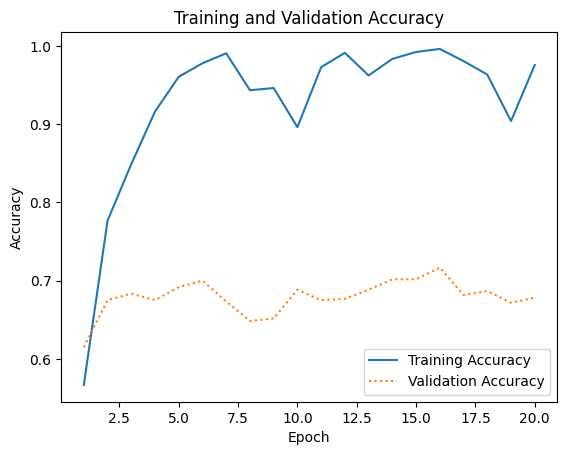

In [17]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [54]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [55]:
history = CNNmodel.fit(x_train, y_train, epochs=20, validation_data= (x_test, y_test))

Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 13.9307 - accuracy: 0.0667 - val_loss: 294.1543 - val_accuracy: 0.6000
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 1020.7750 - accuracy: 0.1333 - val_loss: 253.3155 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 297.9191 - accuracy: 0.2667 - val_loss: 101.7086 - val_accuracy: 0.2000
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 168.3641 - accuracy: 0.1333 - val_loss: 27.1738 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 67.7248 - accuracy: 0.2667 - val_loss: 3.1554 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 25.1614 - accuracy: 0.0667 - val_loss: 3.1720 - val_accuracy: 0.2000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 8.4251 - accuracy: 0.2000 - val_loss: 3.1712 - val_accuracy: 0.2000
Epoch 8/20
1

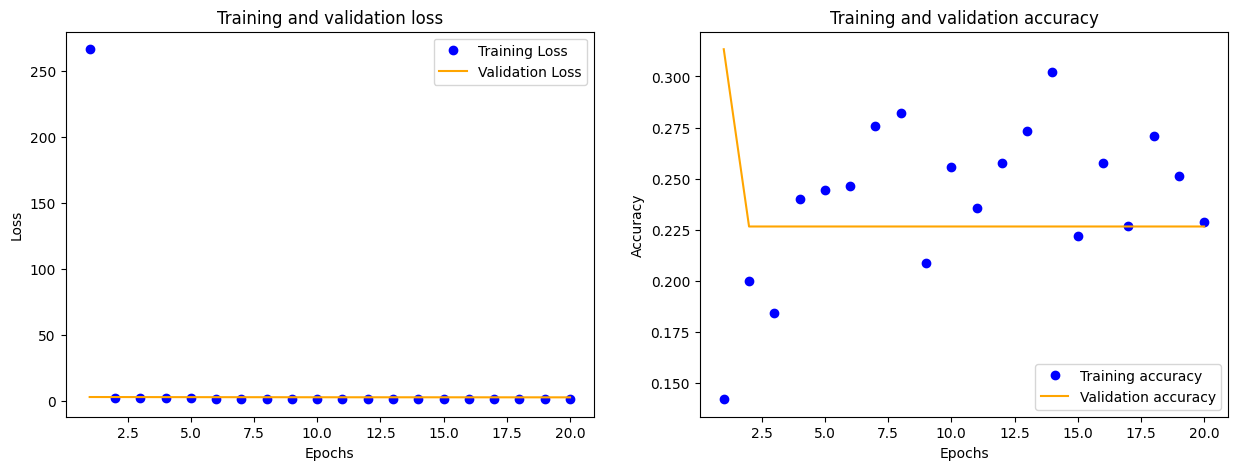

In [22]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [18]:
from sklearn.metrics import precision_score

def class_precisions(y_true, y_pred, classes):
    precisions = []
    for class_label in classes:
        # Create binary arrays for the current class
        y_true_class = [1 if label == class_label else 0 for label in y_true]
        y_pred_class = [1 if label == class_label else 0 for label in y_pred]
        # Calculate precision for the current class
        precision = precision_score(y_true_class, y_pred_class)
        precisions.append(precision)
    return precisions

def get_label_specific_accuracy(y_true, y_pred, classes):
    class_precisions_values = class_precisions(y_true, y_pred, classes)
    for class_label, precision in enumerate(class_precisions_values):
        print(f"Precision for class {classes[class_label]}: {precision}")

In [24]:
# model.predict(x_test_norm)
def convertToClasses(Arr):
    a = []
    for i in Arr:
        val = 0
        position = 0
        for j,k in enumerate(i):
            if k>val:
                position = j
                val = k
        a.append(observed_emotions[position])
    return a

In [32]:
y_pred = model1.predict(test_features)

19/19 [==============================] - 3s 72ms/step


In [33]:
y_pred

array([[7.8585881e-01, 1.1214562e-03, 4.1388626e-05, 2.1297835e-01],
       [3.8015102e-09, 1.9644827e-05, 2.9690757e-11, 9.9998033e-01],
       [5.3807534e-04, 2.8807665e-06, 1.1759108e-08, 9.9945909e-01],
       ...,
       [4.1306420e-04, 2.2846423e-14, 9.9958700e-01, 1.2086057e-11],
       [2.2284700e-02, 9.3523016e-11, 9.7771478e-01, 4.3400348e-07],
       [9.8387194e-01, 1.4888221e-09, 1.6127875e-02, 2.0141131e-07]],
      dtype=float32)

In [34]:
y_pred_labels = convertToClasses(y_pred)
observed_emotions

['Happy', 'Sad', 'Angry', 'Neutral']

In [35]:
y_pred_labels

['Happy',
 'Neutral',
 'Neutral',
 'Sad',
 'Neutral',
 'Happy',
 'Angry',
 'Angry',
 'Happy',
 'Neutral',
 'Neutral',
 'Angry',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Happy',
 'Neutral',
 'Happy',
 'Neutral',
 'Neutral',
 'Sad',
 'Neutral',
 'Angry',
 'Neutral',
 'Neutral',
 'Angry',
 'Happy',
 'Sad',
 'Angry',
 'Happy',
 'Neutral',
 'Happy',
 'Neutral',
 'Neutral',
 'Sad',
 'Angry',
 'Sad',
 'Angry',
 'Angry',
 'Neutral',
 'Sad',
 'Happy',
 'Happy',
 'Angry',
 'Angry',
 'Neutral',
 'Neutral',
 'Sad',
 'Happy',
 'Neutral',
 'Happy',
 'Neutral',
 'Happy',
 'Angry',
 'Happy',
 'Neutral',
 'Angry',
 'Neutral',
 'Happy',
 'Angry',
 'Angry',
 'Happy',
 'Sad',
 'Happy',
 'Neutral',
 'Angry',
 'Sad',
 'Happy',
 'Angry',
 'Sad',
 'Happy',
 'Sad',
 'Happy',
 'Neutral',
 'Neutral',
 'Sad',
 'Happy',
 'Angry',
 'Neutral',
 'Angry',
 'Angry',
 'Happy',
 'Happy',
 'Neutral',
 'Neutral',
 'Sad',
 'Sad',
 'Happy',
 'Happy',
 'Happy',
 'Sad',
 'Sad',
 'Angry',
 'Angry',
 'Sad',
 'Sad',
 'An

In [36]:
y_true_labels = convertToClasses(y_test_encoded)
y_true_labels

['Neutral',
 'Neutral',
 'Happy',
 'Angry',
 'Happy',
 'Happy',
 'Angry',
 'Happy',
 'Happy',
 'Sad',
 'Sad',
 'Angry',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Happy',
 'Sad',
 'Angry',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Angry',
 'Neutral',
 'Sad',
 'Angry',
 'Happy',
 'Sad',
 'Happy',
 'Happy',
 'Angry',
 'Happy',
 'Neutral',
 'Neutral',
 'Happy',
 'Sad',
 'Sad',
 'Happy',
 'Angry',
 'Neutral',
 'Neutral',
 'Angry',
 'Happy',
 'Angry',
 'Happy',
 'Sad',
 'Neutral',
 'Happy',
 'Happy',
 'Sad',
 'Neutral',
 'Neutral',
 'Sad',
 'Angry',
 'Happy',
 'Neutral',
 'Angry',
 'Neutral',
 'Happy',
 'Angry',
 'Happy',
 'Happy',
 'Sad',
 'Happy',
 'Happy',
 'Happy',
 'Neutral',
 'Angry',
 'Angry',
 'Sad',
 'Neutral',
 'Sad',
 'Angry',
 'Neutral',
 'Neutral',
 'Sad',
 'Sad',
 'Angry',
 'Neutral',
 'Angry',
 'Angry',
 'Happy',
 'Happy',
 'Sad',
 'Angry',
 'Angry',
 'Sad',
 'Happy',
 'Happy',
 'Happy',
 'Sad',
 'Sad',
 'Angry',
 'Happy',
 'Sad',
 'Angry',
 'Angry',
 'Sad',
 '

In [37]:
get_label_specific_accuracy(y_true_labels,y_pred_labels,observed_emotions)

Precision for class Happy: 0.6639344262295082
Precision for class Sad: 0.8165137614678899
Precision for class Angry: 0.732484076433121
Precision for class Neutral: 0.5754716981132075
